### Classifier

explain about the notebook

### Import modules

In [2]:
import keras
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam

import numpy as np
import time
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.
/home/feaf-seat-1/.virtualenvs/nesvera_keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/feaf-seat-1/.virtualenvs/nesvera_keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/feaf-seat-1/.virtualenvs/nesvera_keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

### Variables declaration

Variable input_image_size: 
The input of classifier (neural net) is a image (matrix) of size (224, 224, 3)

Variable mobiletnet_alpha:
Alpha: controls the width of the network. 
This is known as the width multiplier in the MobileNetV2 paper.
If alpha < 1.0, proportionally decreases the number of filters in each layer.
If alpha > 1.0, proportionally increases the number of filters in each layer.
If alpha = 1, default number of filters from the paper are used at each layer.

Papers:
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Mobilenet V1)
https://arxiv.org/abs/1704.04861

MobileNetV2: Inverted Residuals and Linear Bottlenecks
http://openaccess.thecvf.com/content_cvpr_2018/html/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.html

In [63]:
output_model_path = "/home/feaf-seat-1/Documents/nesvera/lecture/mobilenets/model"

input_image_size = 224
mobiletnet_alpha = 0.5

batch_size = 32

classes = ['background',
           'chicken',
           'pedestrian',
           'traf_sign_60',
           'traf_sign_free',
           'traf_sign_stop']

# Path for train and validation datasets
dataset_train_path = "/home/feaf-seat-1/Documents/nesvera/lecture/dataset/ready_dataset/train"
dataset_valid_path = "/home/feaf-seat-1/Documents/nesvera/lecture/dataset/ready_dataset/validation"


### Functions declaration

Info about MobileNetV2 function https://keras.io/applications/#mobilenetv2

In [64]:
def build_mobilenet_v2(image_size, alpha, classes):
    
    # how many classes do we have
    num_classes = len(classes)

    # Load moblenetv2 without the class classification layers
    base_model = MobileNetV2(input_shape=(image_size, image_size, 3), 
                        alpha=alpha,  
                        include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        pooling=None, 
                        classes=1000)

    # freeze layer already trained with imagenet
    #for layer in base_model.layers:
    #    layer.trainable = False

    # Append new class classificaiton layers
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model
    
def import_model():
    pass

def load_dataset():
    pass

def plot_images(images, fig_size=(12,6), rows=1, interp=False, titles=None):
    
    if type(images[0]) is np.ndarray:
        images = np.array(images).astype(np.uint8)
        if images.shape[-1] != 3:
            images = images.transpose((0, 2, 3, 1))
        
    fig = plt.figure(figsize=fig_size)
    cols = len(images)//rows if len(images)%2 == 0 else len(images)//rows + 1
    
    for ind, image in enumerate(images):
        sub_plot = fig.add_subplot(rows, cols, ind+1)
        sub_plot.axis('Off')
        
        if titles is not None:
            sub_plot.set_title(titles[ind], fontsize=16)
            
        plt.imshow(image, interpolation=None if interp else 'none')
    
def plot_filters(images, fig_size=(12,6), rows=1, interp=False, titles=None):
    
    #if type(images[0]) is np.ndarray:
    #    images = np.array(images).astype(np.uint8)
    #    if images.shape[-1] != 3:
    #        images = images.transpose((0, 2, 3, 1))
        
    v_min = np.min(images)
    v_max = np.max(images)
    
    fig = plt.figure(figsize=fig_size)
    cols = len(images)//rows if len(images)%2 == 0 else len(images)//rows + 1
    
    for ind, image in enumerate(images):
        sub_plot = fig.add_subplot(rows, cols, ind+1)
        sub_plot.axis('Off')
        
        if titles is not None:
            sub_plot.set_title(titles[ind], fontsize=16)
        plt.imshow(image, interpolation=None if interp else 'none', cmap='gray', vmin=v_min, vmax=v_max)
        
        for i in range(3):
            for j in range(3):
                sub_plot.text(j, i, round(image[i, j],2), ha="center", va="center", color="w")
        
    fig.savefig('/home/nesvera/Documents/ostfalia/driverless_lecture/lecture/to1.png') 

### Load model

In [65]:
# Build model based on mobilenet v2
model = build_mobilenet_v2(input_image_size, mobiletnet_alpha, classes=classes)

# Show the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Load datasets

In [66]:
#train_batches = ImageDataGenerator().flow_from_directory(dataset_train_path, target_size=(224,224), classes=classes, batch_size=batch_size_train
train_batches = image.ImageDataGenerator().flow_from_directory(dataset_train_path, 
                                                               target_size=(224,224),
                                                               batch_size=batch_size,
                                                               classes=classes)

validation_batches = image.ImageDataGenerator().flow_from_directory(dataset_train_path, 
                                                                    target_size=(224,224), 
                                                                    batch_size=batch_size,
                                                                    classes=classes)

step_size = train_batches.n//train_batches.batch_size
print(step_size)

print("Batch size: " + str(batch_size))
print("Step size: " + str(step_size))

print("\nClasses: ")
for i, class_ in enumerate(classes):
    print("[" + str(i) + "] - " + class_ )

Found 9295 images belonging to 6 classes.
Found 9295 images belonging to 6 classes.
290
Batch size: 32
Step size: 290

Classes: 
[0] - background
[1] - chicken
[2] - pedestrian
[3] - traf_sign_60
[4] - traf_sign_free
[5] - traf_sign_stop


### Dataset demonstration

Present some of the images that are inside the batches

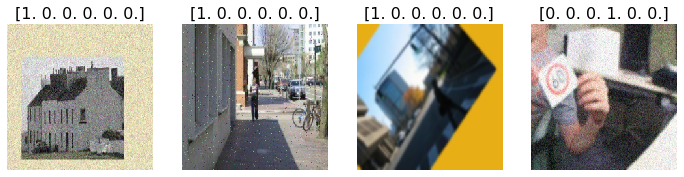

In [67]:
images, labels = next(train_batches)
plot_images(images[0:4], rows=1, interp=False, titles=labels)

### Train configuration

Optimizer:

Losses:

Metrics:


In [68]:
optimizer = Adam(lr=.0001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer, loss=loss, metrics=metrics)

In [69]:
epochs = 10

# number of samples used in an epoch = batch_size * steps_per_epochs

model.fit_generator(train_batches, steps_per_epoch=step_size,
                    validation_data=validation_batches, validation_steps=step_size,
                    epochs=epochs,
                    verbose=1)                 

'''
model.fit_generator(train_batches, steps_per_epoch=4,
                    epochs=epochs,
                    verbose=1)
'''

Epoch 1/10
290/290 [==============================] - 106s 365ms/step - loss: 0.1253 - acc: 0.9644 - val_loss: 0.0155 - val_acc: 0.9942
Epoch 2/10
290/290 [==============================] - 91s 314ms/step - loss: 0.0213 - acc: 0.9916 - val_loss: 0.0093 - val_acc: 0.9963
Epoch 3/10
290/290 [==============================] - 92s 317ms/step - loss: 0.0137 - acc: 0.9940 - val_loss: 0.0061 - val_acc: 0.9976
Epoch 4/10
290/290 [==============================] - 91s 315ms/step - loss: 0.0079 - acc: 0.9961 - val_loss: 0.0041 - val_acc: 0.9982
Epoch 5/10
290/290 [==============================] - 92s 317ms/step - loss: 0.0107 - acc: 0.9964 - val_loss: 0.0105 - val_acc: 0.9964
Epoch 6/10
290/290 [==============================] - 92s 318ms/step - loss: 0.0092 - acc: 0.9961 - val_loss: 0.0036 - val_acc: 0.9985
Epoch 7/10
290/290 [==============================] - 93s 320ms/step - loss: 0.0061 - acc: 0.9975 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 8/10
290/290 [==============================] - 

'\nmodel.fit_generator(train_batches, steps_per_epoch=4,\n                    epochs=epochs,\n                    verbose=1)\n'

### Test

Prediction result: 
Label: traf_sign_free
Accuracy: 100.0


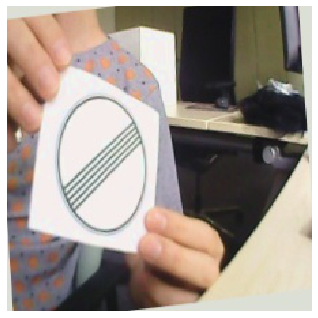

In [79]:
test_image = random.choice(images)
test_image = np.reshape(test_image, (-1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))

predictions = model.predict(test_image)

pred_max_value = np.max(predictions)
pred_max_index = np.argmax(predictions)

plot_images(test_image)
print('Prediction result: ')
print('Label: ' + str(classes[pred_max_index]))
print('Accuracy: ' + str(pred_max_value*100))

### Save model and weights

In [71]:
output_model_h5 = output_model_path + "/mobilenet_0-5_10e_20-08-19_16-08.h5"
model.save(output_model_h5)

### Analyse network

In [112]:
'''
for i, layer in enumerate(model.layers):
    #weights = layer.get_weights() # list of numpy arrays
    weights = np.array(layer.get_weights())
    print(i, weights.shape)
    input()
'''

weights = np.array(model.layers[40].get_weights())
print(weights.shape)

(1, 3, 3, 96, 1)


In [ ]:
filters =  np.reshape(weights[0], (16, 3, 3, 3))
print(filters.shape)

-0.27964717 0.41337186


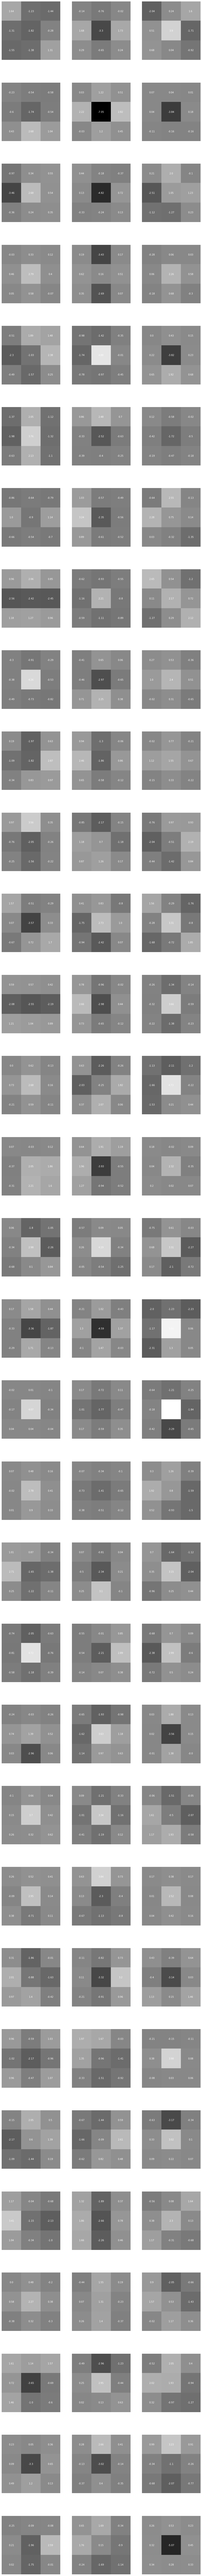

In [150]:
to_print = np.zeros((96,3,3))
for i in range(96):
        to_print[i] = weights[0,:,:,i,0]

plot_filters(to_print, rows=32, fig_size=(15,200))

